In [23]:
using ITensors, ITensorMPS
using LinearAlgebra
using SparseArrays
using Plots

In [3]:
include("src/main.jl")
include("src/observables.jl")
include("src/states.jl")
include("src/doubled_measurements.jl")

forced_doubled_measure_with_val (generic function with 2 methods)

In [4]:
include("mps.jl")

rand_X_weak_measurement_layer (generic function with 1 method)

In [5]:
function MPS_update_data(ρ::MPS, observables::Vector{Symbol}, data::Dict{Symbol,Vector{Float64}}, t::Int)
    if :Ic in observables
        data[:Ic][t] = Ic2(ρ)
    end
    if :SR in observables
        data[:SR][t] = SR(ρ)
    end
    if :κEA in observables
        data[:κEA][t] = κEA(ρ)
    end
    if :κ2 in observables
        data[:κ2][t] = κ2(ρ)
    end
    if :maxlinkdim in observables
        data[:maxlinkdim][t] = maxlinkdim(ρ)
    end
    return data
end

MPS_update_data (generic function with 1 method)

In [6]:
function circuit(L::Int, T::Int, λ::Float64, δ::Float64, q::Float64; observables=Symbol[], cutoff=1E-8, maxdim=200)
    ρ, sites = ghz(L)

    data = Dict([s => zeros(Float64, T+1) for s in observables])
    data = MPS_update_data(ρ, observables, data, 1)

    K = atanh(q/(1-q))
    Xn = X_noise_layer(K, sites; reference=true)
    ZZn = ZZ_noise_layer(K, sites; reference=true)
    bell_state = bell(sites)

    λzz = δ*(1-λ)
    λx = δ*λ

    for t in 1:T
        ρ = rand_X_weak_measurement_layer(ρ, sites, λx; reference=true)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        ρ = apply(Xn, ρ)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        ρ = rand_ZZ_weak_measurement_layer(ρ, sites, λzz; reference=true)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        ρ = apply(ZZn, ρ)
        ρ /= inner(bell_state, ρ)
        truncate!(ρ; cutoff=cutoff, maxdim=maxdim)

        data = MPS_update_data(ρ, observables, data, t+1)
    end

    return ρ, data
end

circuit (generic function with 1 method)

In [ ]:
L = 8
# observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
observables = Symbol[]

ρ, data = circuit(L, L, 0.5, 0.5, 0.0; observables=observables)
data

In [75]:
Base.summarysize(ρ)

1878624

In [8]:
L = 4
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
# observables = Symbol[]

ρ, data = circuit(L, 2L, 0.4, 0.7, 0.1; observables=observables)
data

Dict{Symbol, Vector{Float64}} with 5 entries:
  :κEA        => [4.0, 3.12127, 1.18879, 1.77035, 1.18965, 1.16697, 1.17826, 1.…
  :SR         => [1.0, 0.996102, 0.830513, 0.808103, 0.908528, 0.802629, 0.9227…
  :maxlinkdim => [4.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0, 16.0]
  :Ic         => [1.0, 0.971833, 0.256176, 0.172159, 0.162206, 0.018068, 0.0116…
  :κ2         => [4.0, 3.85463, 2.62459, 3.24931, 3.24294, 2.87639, 3.48233, 3.…

In [15]:
function sample(L::Int, T::Int, λ::Float64, δ::Float64, q::Float64, samples::Int; observables=Symbol[], cutoff=1E-8, maxdim=200)
    mean_data = Dict([s => zeros(Float64, T+1) for s in observables])
    for _ in 1:samples
        _, sample_data = circuit(L, T, λ, δ, q; observables=observables)
        for observable in observables
            mean_data[observable] += sample_data[observable]
        end
    end
    for observable in observables
        mean_data[observable] /= samples
    end
    return mean_data
end

sample (generic function with 1 method)

In [36]:
L = 4
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
# observables = Symbol[]

data = sample(L, 2L, 0.0, 0.7, 0.2, 100; observables=observables)
data

Dict{Symbol, Vector{Float64}} with 5 entries:
  :κEA        => [4.0, 2.85975, 2.47025, 2.27806, 2.22025, 2.18593, 2.14839, 2.…
  :SR         => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
  :maxlinkdim => [4.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 7.98, 8.0]
  :Ic         => [1.0, 0.717043, 0.48034, 0.307858, 0.21533, 0.152383, 0.107701…
  :κ2         => [4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0]

In [37]:
L = 8
observables = Symbol[:κEA, :κ2, :Ic, :SR, :maxlinkdim]
# observables = Symbol[]

data2 = sample(L, 2L, 0.0, 0.7, 0.2, 100; observables=observables)
data2

Dict{Symbol, Vector{Float64}} with 5 entries:
  :κEA        => [8.0, 5.78875, 5.48724, 5.16516, 4.84684, 4.67721, 4.42606, 4.…
  :SR         => [1.0, 1.0, 1.00002, 1.0, 1.00001, 1.00001, 1.0, 1.0, 1.0, 1.00…
  :maxlinkdim => [4.0, 8.0, 9.12, 9.13, 9.92, 9.75, 9.87, 9.57, 9.52, 9.69, 9.4…
  :Ic         => [1.0, 0.897827, 0.797541, 0.663069, 0.557309, 0.435949, 0.3531…
  :κ2         => [8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8…

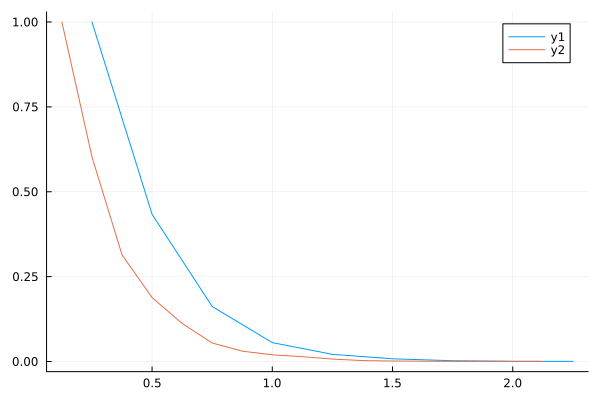

In [35]:
plot(collect(1:9)/4, data[:Ic])
plot!(collect(1:17)/8, data2[:Ic])